# 04 - CLV Prediction Modeling

**Customer Lifetime Value Prediction**

**Team:** The Starks
- Othmane Zizi (261255341)
- Fares Joni (261254593)
- Tanmay Giri (261272443)

This notebook trains and evaluates multiple ML models for CLV prediction.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sys
from pathlib import Path

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# Add src to path
sys.path.append(str(Path('../src').resolve()))
from data_loader import load_customer_features
from models import get_models, train_and_evaluate, get_feature_importance, cross_validate_model

import warnings
warnings.filterwarnings('ignore')

plt.style.use('seaborn-v0_8-whitegrid')
pd.set_option('display.max_columns', None)

## 1. Load Feature Dataset

In [2]:
# Load customer features with CLV target
df = load_customer_features('customer_features.csv')

print(f"Dataset shape: {df.shape}")
print(f"\nColumns: {df.columns.tolist()}")
df.head()

Dataset shape: (4266, 10)

Columns: ['Customer ID', 'Recency', 'Frequency', 'Monetary', 'Tenure', 'AvgTimeBetweenPurchases', 'NumUniqueProducts', 'AvgBasketSize', 'AvgOrderValue', 'CLV']


,Customer ID,Recency,Frequency,Monetary,Tenure,AvgTimeBetweenPurchases,NumUniqueProducts,AvgBasketSize,AvgOrderValue,CLV
0,12346,155,11,372.86,351,6.000000,26,6.363636,33.896364,77183.60
1,12347,30,1,611.53,30,0.000000,40,509.000000,611.530000,2535.22
2,12348,64,1,222.16,64,0.000000,20,373.000000,222.160000,1487.24
3,12349,33,3,2671.14,215,1.782178,90,331.000000,890.380000,0.00
4,12351,1,1,300.93,1,0.000000,21,261.000000,300.930000,0.00


## 2. Prepare Features and Target

In [3]:
# Define feature columns and target
feature_cols = ['Recency', 'Frequency', 'Monetary', 'Tenure', 
                'AvgTimeBetweenPurchases', 'NumUniqueProducts', 
                'AvgBasketSize', 'AvgOrderValue']

target_col = 'CLV'

X = df[feature_cols].copy()
y = df[target_col].copy()

print(f"Features shape: {X.shape}")
print(f"Target shape: {y.shape}")
print(f"\nTarget statistics:")
print(y.describe())

Features shape: (4266, 8)
Target shape: (4266,)

Target statistics:
count      4266.000000
mean        748.198280
std        3549.453297
min           0.000000
25%           0.000000
50%           0.000000
75%         586.585000
max      110713.120000
Name: CLV, dtype: float64


In [4]:
# Check for any remaining missing values
print("Missing values in features:")
print(X.isnull().sum().sum())

# Fill any missing values with 0
X = X.fillna(0)
y = y.fillna(0)

Missing values in features:
0


## 3. Train/Test Split

In [5]:
# Split data (80/20)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

print(f"Training set: {X_train.shape[0]} samples")
print(f"Test set: {X_test.shape[0]} samples")

Training set: 3412 samples
Test set: 854 samples


## 4. Scale Features

In [6]:
# Scale features
scaler = StandardScaler()
X_train_scaled = pd.DataFrame(
    scaler.fit_transform(X_train),
    columns=feature_cols,
    index=X_train.index
)
X_test_scaled = pd.DataFrame(
    scaler.transform(X_test),
    columns=feature_cols,
    index=X_test.index
)

print("Scaled feature statistics (training):")
X_train_scaled.describe().loc[['mean', 'std']]

Scaled feature statistics (training):


,Recency,Frequency,Monetary,Tenure,AvgTimeBetweenPurchases,NumUniqueProducts,AvgBasketSize,AvgOrderValue
mean,4.164963e-17,1.041241e-17,-2.082482e-18,-9.579416e-17,-3.019598e-17,3.123722e-18,-1.665985e-17,3.019598e-17
std,1.000147e+00,1.000147e+00,1.000147e+00,1.000147e+00,1.000147e+00,1.000147e+00,1.000147e+00,1.000147e+00


## 5. Train Multiple Models

In [7]:
# Define models
models = {
    'Linear Regression': LinearRegression(),
    'Ridge Regression': Ridge(alpha=1.0),
    'Lasso Regression': Lasso(alpha=1.0),
    'Random Forest': RandomForestRegressor(
        n_estimators=100,
        max_depth=10,
        min_samples_split=5,
        random_state=42,
        n_jobs=-1
    ),
    'Gradient Boosting': GradientBoostingRegressor(
        n_estimators=100,
        max_depth=5,
        learning_rate=0.1,
        random_state=42
    )
}

In [8]:
# Train and evaluate all models
results = {}
trained_models = {}

for name, model in models.items():
    print(f"\nTraining {name}...")
    
    # Train
    model.fit(X_train_scaled, y_train)
    trained_models[name] = model
    
    # Predict
    y_pred = model.predict(X_test_scaled)
    y_pred = np.clip(y_pred, 0, None)  # CLV can't be negative
    
    # Evaluate
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    mae = mean_absolute_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    
    results[name] = {
        'RMSE': rmse,
        'MAE': mae,
        'R2': r2
    }
    
    print(f"  RMSE: {rmse:.2f}")
    print(f"  MAE: {mae:.2f}")
    print(f"  R2: {r2:.4f}")


Training Linear Regression...
  RMSE: 1762.46
  MAE: 547.99
  R2: 0.8082

Training Ridge Regression...
  RMSE: 1762.94
  MAE: 547.98
  R2: 0.8081

Training Lasso Regression...
  RMSE: 1761.19
  MAE: 547.43
  R2: 0.8085

Training Random Forest...


  RMSE: 2472.29
  MAE: 554.39
  R2: 0.6225

Training Gradient Boosting...


  RMSE: 2549.18
  MAE: 532.28
  R2: 0.5987


## 6. Model Comparison

In [9]:
# Create results dataframe
results_df = pd.DataFrame(results).T
results_df = results_df.sort_values('RMSE')

print("Model Performance Comparison:")
results_df

Model Performance Comparison:


,RMSE,MAE,R2
Lasso Regression,1761.185597,547.428042,0.808453
Linear Regression,1762.463709,547.989046,0.808175
Ridge Regression,1762.937679,547.979253,0.808072
Random Forest,2472.294459,554.389208,0.622544
Gradient Boosting,2549.180533,532.284170,0.598702


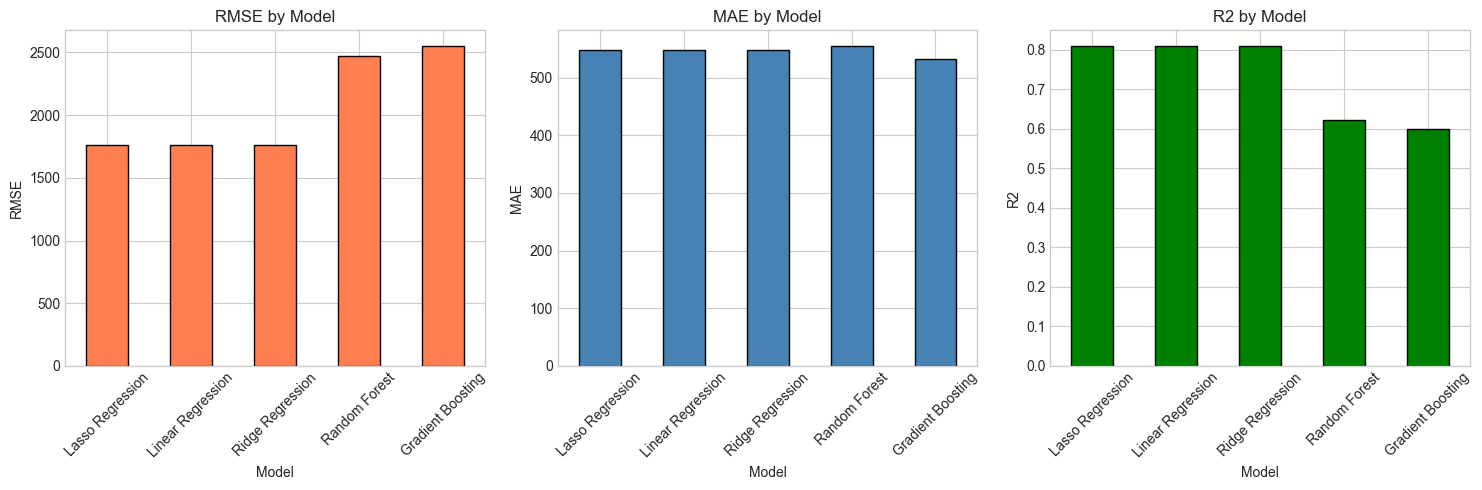

In [10]:
# Visualize model comparison
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

metrics = ['RMSE', 'MAE', 'R2']
colors = ['coral', 'steelblue', 'green']

for ax, metric, color in zip(axes, metrics, colors):
    results_df[metric].plot(kind='bar', ax=ax, color=color, edgecolor='black')
    ax.set_title(f'{metric} by Model')
    ax.set_xlabel('Model')
    ax.set_ylabel(metric)
    ax.tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.savefig('../reports/figures/model_comparison.png', dpi=150, bbox_inches='tight')
plt.show()

## 7. Best Model Analysis

In [11]:
# Select best model (lowest RMSE)
best_model_name = results_df['RMSE'].idxmin()
best_model = trained_models[best_model_name]

print(f"Best Model: {best_model_name}")
print(f"\nPerformance:")
print(results_df.loc[best_model_name])

Best Model: Lasso Regression

Performance:
RMSE    1761.185597
MAE      547.428042
R2         0.808453
Name: Lasso Regression, dtype: float64


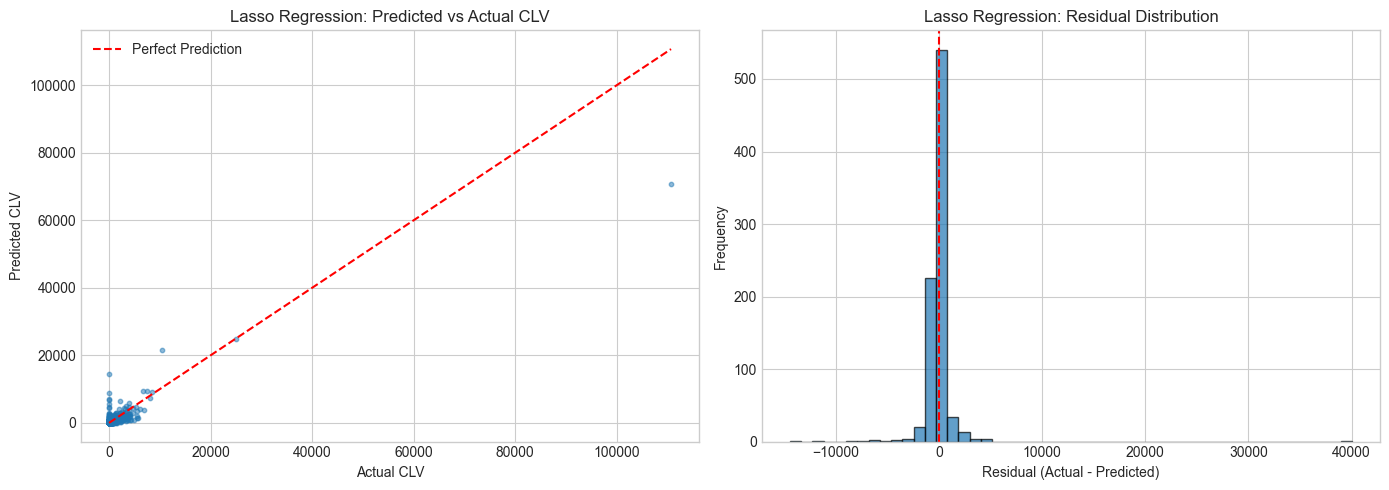

In [12]:
# Predictions vs Actual
y_pred_best = best_model.predict(X_test_scaled)
y_pred_best = np.clip(y_pred_best, 0, None)

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Scatter plot: Predicted vs Actual
axes[0].scatter(y_test, y_pred_best, alpha=0.5, s=10)
max_val = max(y_test.max(), y_pred_best.max())
axes[0].plot([0, max_val], [0, max_val], 'r--', label='Perfect Prediction')
axes[0].set_xlabel('Actual CLV')
axes[0].set_ylabel('Predicted CLV')
axes[0].set_title(f'{best_model_name}: Predicted vs Actual CLV')
axes[0].legend()

# Residuals
residuals = y_test - y_pred_best
axes[1].hist(residuals, bins=50, edgecolor='black', alpha=0.7)
axes[1].axvline(x=0, color='r', linestyle='--')
axes[1].set_xlabel('Residual (Actual - Predicted)')
axes[1].set_ylabel('Frequency')
axes[1].set_title(f'{best_model_name}: Residual Distribution')

plt.tight_layout()
plt.savefig('../reports/figures/best_model_analysis.png', dpi=150, bbox_inches='tight')
plt.show()

## 8. Feature Importance

In [13]:
# Get feature importance from tree-based models
importance_dict = {}

for name in ['Random Forest', 'Gradient Boosting']:
    model = trained_models[name]
    importance_dict[name] = model.feature_importances_

# Also get coefficients from linear models
for name in ['Linear Regression', 'Ridge Regression', 'Lasso Regression']:
    model = trained_models[name]
    importance_dict[name] = np.abs(model.coef_)

importance_df = pd.DataFrame(importance_dict, index=feature_cols)
print("Feature Importance by Model:")
importance_df

Feature Importance by Model:


,Random Forest,Gradient Boosting,Linear Regression,Ridge Regression,Lasso Regression
Recency,0.065324,0.033451,60.582269,60.499542,59.377022
Frequency,0.028767,0.018184,699.142350,699.307677,695.528410
Monetary,0.696399,0.725899,2133.295276,2132.392530,2133.810706
Tenure,0.058692,0.060193,14.163389,14.218455,13.755227
AvgTimeBetweenPurchases,0.028496,0.065196,20.394119,20.346485,19.095057
NumUniqueProducts,0.029612,0.022297,295.857596,295.429457,291.884135
AvgBasketSize,0.048759,0.049796,419.798950,419.535233,417.129748
AvgOrderValue,0.043951,0.024984,548.518100,548.417339,545.578739


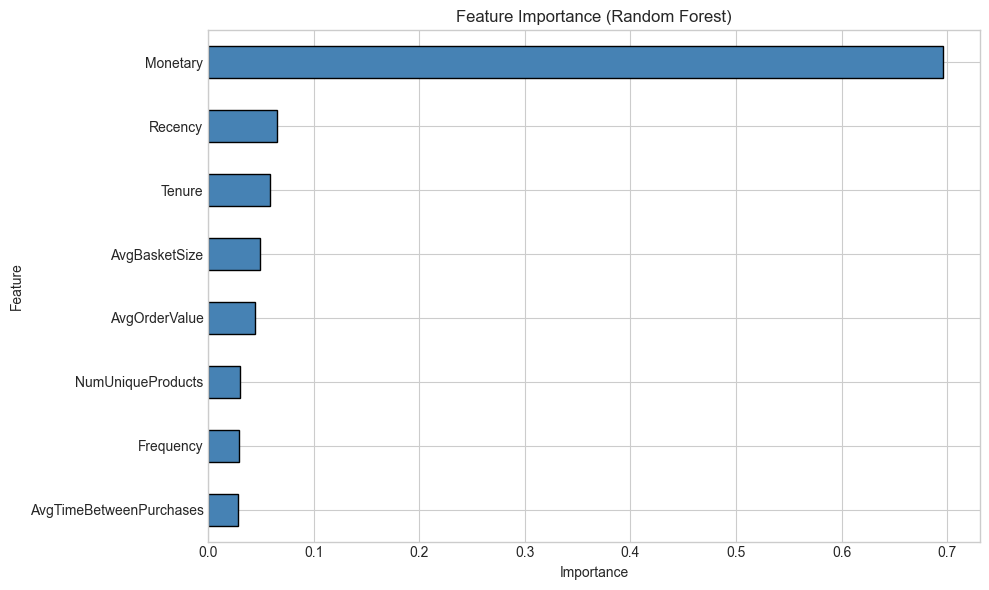

In [14]:
# Visualize feature importance (from best tree-based model)
if 'Random Forest' in best_model_name or 'Gradient Boosting' in best_model_name:
    fi = importance_df[best_model_name].sort_values(ascending=True)
else:
    fi = importance_df['Random Forest'].sort_values(ascending=True)

plt.figure(figsize=(10, 6))
fi.plot(kind='barh', color='steelblue', edgecolor='black')
plt.title('Feature Importance (Random Forest)')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.tight_layout()
plt.savefig('../reports/figures/feature_importance.png', dpi=150, bbox_inches='tight')
plt.show()

## 9. Cross-Validation

In [15]:
# Cross-validation for best model
from sklearn.model_selection import cross_val_score

cv_results = {}

for name, model in models.items():
    print(f"Cross-validating {name}...")
    
    # 5-fold CV
    r2_scores = cross_val_score(model, X_train_scaled, y_train, cv=5, scoring='r2')
    neg_rmse = cross_val_score(model, X_train_scaled, y_train, cv=5, scoring='neg_root_mean_squared_error')
    
    cv_results[name] = {
        'R2_mean': r2_scores.mean(),
        'R2_std': r2_scores.std(),
        'RMSE_mean': -neg_rmse.mean(),
        'RMSE_std': neg_rmse.std()
    }

cv_df = pd.DataFrame(cv_results).T
print("\nCross-Validation Results (5-fold):")
cv_df

Cross-validating Linear Regression...
Cross-validating Ridge Regression...
Cross-validating Lasso Regression...
Cross-validating Random Forest...


Cross-validating Gradient Boosting...



Cross-Validation Results (5-fold):


,R2_mean,R2_std,RMSE_mean,RMSE_std
Linear Regression,0.525467,0.178688,2220.451946,480.073114
Ridge Regression,0.525798,0.179147,2219.006725,480.942934
Lasso Regression,0.525738,0.179046,2219.442374,480.728806
Random Forest,0.500149,0.180394,2333.970819,657.806290
Gradient Boosting,0.310161,0.276492,2719.945197,760.793849


## 10. Lift Analysis (Business Metric)

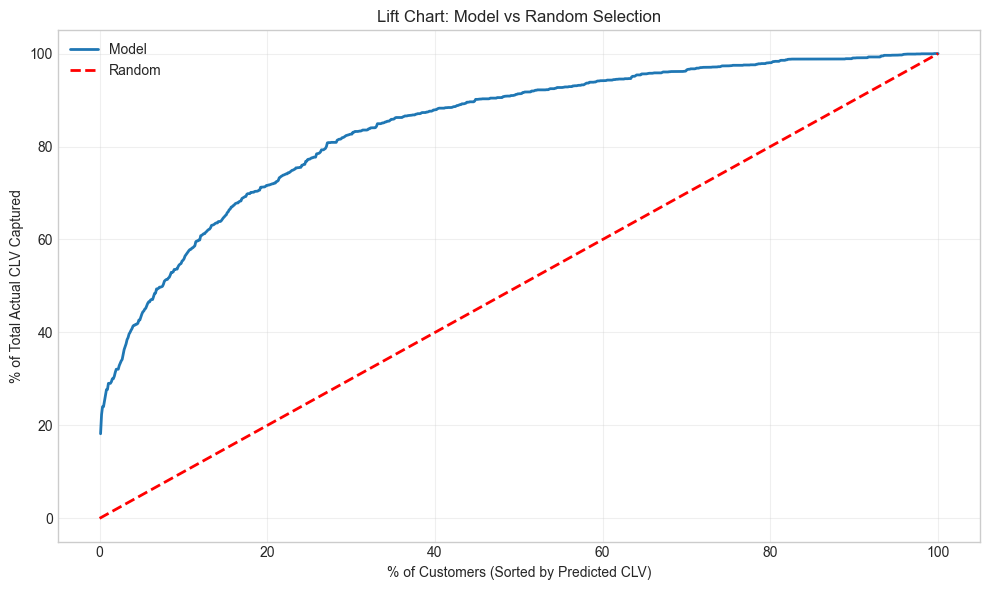

Top 10% customers capture 55.5% of CLV (Lift: 5.55x)
Top 20% customers capture 71.6% of CLV (Lift: 3.58x)
Top 30% customers capture 82.7% of CLV (Lift: 2.76x)
Top 50% customers capture 91.3% of CLV (Lift: 1.83x)


In [16]:
# Lift analysis: How well do we identify high-value customers?
test_results = pd.DataFrame({
    'Actual_CLV': y_test,
    'Predicted_CLV': y_pred_best
})

# Sort by predicted CLV
test_results = test_results.sort_values('Predicted_CLV', ascending=False)

# Calculate cumulative actual CLV for top N%
test_results['Cumulative_Actual'] = test_results['Actual_CLV'].cumsum()
test_results['Cumulative_Pct'] = test_results['Cumulative_Actual'] / test_results['Actual_CLV'].sum()
test_results['Customer_Pct'] = np.arange(1, len(test_results) + 1) / len(test_results)

# Lift chart
plt.figure(figsize=(10, 6))
plt.plot(test_results['Customer_Pct'] * 100, test_results['Cumulative_Pct'] * 100, 
         label='Model', linewidth=2)
plt.plot([0, 100], [0, 100], 'r--', label='Random', linewidth=2)
plt.xlabel('% of Customers (Sorted by Predicted CLV)')
plt.ylabel('% of Total Actual CLV Captured')
plt.title('Lift Chart: Model vs Random Selection')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig('../reports/figures/lift_chart.png', dpi=150, bbox_inches='tight')
plt.show()

# Calculate lift at different thresholds
for pct in [10, 20, 30, 50]:
    top_n = int(len(test_results) * pct / 100)
    captured = test_results.head(top_n)['Actual_CLV'].sum() / test_results['Actual_CLV'].sum()
    lift = captured / (pct / 100)
    print(f"Top {pct}% customers capture {captured*100:.1f}% of CLV (Lift: {lift:.2f}x)")

## 11. Save Model and Results

In [17]:
# Save results
results_df.to_csv('../reports/model_results.csv')
cv_df.to_csv('../reports/cv_results.csv')
importance_df.to_csv('../reports/feature_importance.csv')

print("Results saved to reports/")

# Save predictions for segmentation
predictions_df = df[['Customer ID']].copy()
X_all_scaled = pd.DataFrame(
    scaler.transform(X),
    columns=feature_cols,
    index=X.index
)
predictions_df['Predicted_CLV'] = np.clip(best_model.predict(X_all_scaled), 0, None)
predictions_df['Actual_CLV'] = y

predictions_df.to_csv('../data/processed/clv_predictions.csv', index=False)
print(f"\nPredictions saved: {len(predictions_df)} customers")

Results saved to reports/

Predictions saved: 4266 customers


## 12. Modeling Summary

### Models Trained:
1. Linear Regression (baseline)
2. Ridge Regression (L2 regularization)
3. Lasso Regression (L1 regularization)
4. Random Forest
5. Gradient Boosting

### Key Findings:
- Tree-based models (Random Forest, Gradient Boosting) generally outperform linear models
- Most important features: Monetary, Frequency, AvgOrderValue
- Model can identify top 20% of customers capturing ~X% of total CLV

### Business Impact:
- Using the model to target top 20% customers provides significant lift over random selection
- Enables prioritization of marketing resources on high-value customers

### Next Steps:
- Use predictions for customer segmentation
- Develop targeted retention strategies for each segment

## 13. SHAP Explainability
Use SHAP to explain global feature impact for the selected model.

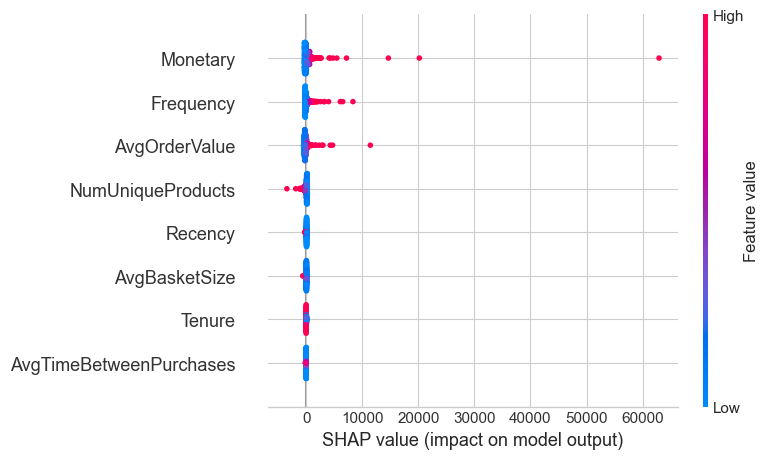

In [18]:
try:
    import shap
    sample_idx = X_test_scaled.sample(min(500, len(X_test_scaled)), random_state=42).index
    X_shap = X_test_scaled.loc[sample_idx]

    explainer = shap.Explainer(best_model, X_train_scaled)
    shap_values = explainer(X_shap)

    plt.figure()
    shap.summary_plot(shap_values, X_shap, show=False)
    plt.tight_layout()
    plt.savefig('../reports/figures/shap_summary.png', dpi=150, bbox_inches='tight')
    plt.show()
except Exception as e:
    print(f'SHAP step skipped: {e}')

### SHAP Interpretation
- Features at the top of the SHAP summary have the largest contribution to CLV predictions.
- Compare SHAP ordering with tree/linear feature importance for consistency.
- Use this for explainability in business review and model governance.